# Modelbuilder
This notebook presents the basic features of the modelbuilder proof of concept. It generates a D-Flow FM model from scratch with only a lat/lon box as input. Since this is a proof of concept, many functions/inputs will change in the future but this notebook will be updated accordingly.

This modelbuilder combines many other Python packages. We use [MeshKernelPy](https://github.com/Deltares/MeshKernelPy) for grid generation, [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) to write all D-Flow FM files (like *.mdu, *.ext, *.bc), [xarray](https://github.com/pydata/xarray) to process netcdf files and [xugrid](https://github.com/Deltares/xugrid) to process ugrid netcdf files. Everything is wrapped in [dfm_tools](https://github.com/Deltares/dfm_tools) which also provide additional features.

A more advanced example of model building is available at [the dfm_tools Github](https://github.com/Deltares/dfm_tools/blob/main/tests/examples/preprocess_modelbuilder.py).

### Exercises
Each block in this notebook has some exercises. It is recommended to first walk trough the entire notebook without doing the exercises to understand the modelbuilding process. If you want to discover more, you can use these exercises as a first step.

## 1. Registering for data retrieval
In this notebook we use publicly available data from Copernicus Programme of the European Union. To access this data you need to create accounts at [Copernicus Marine Service](https://data.marine.copernicus.eu/register) and the [Climate Data Store](https://cds.climate.copernicus.eu/user/register). Do not forget to accept the CDS license agreement. You will be promted for your CMEMS credentials and CDS apikey by this notebook automatically and they will be stored locally. If you want to avoid the prompt, set the environment variables COPERNICUS_MARINE_SERVICE_USERNAME, COPERNICUS_MARINE_SERVICE_PASSWORD and CDSAPI_KEY (format for the latter is `{uid}:{apikey}`).

## 2. Imports and user variables
We start by importing the libraries that are used in this notebook and setting some user input variables that for instance define the spatial and time extent of the resulting model.

### Exercises
- change/extend the model simulation period (`date_min` and `date_max` variables)
- create a new `model_name` and corresponding domain (`lon_min`, `lon_max`, `lat_min`, `lat_max` variables). Use an area of approximately 1x1 degrees for a quick test.


In [1]:
# import packages
import os
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
import hydrolib.core.dflowfm as hcdfm
import xarray as xr
import pandas as pd
import numpy as np
import contextily as ctx


In [2]:
# user input
model_name = 'Vietnam'
dir_output = os.path.abspath(f'./{model_name}_model')
# path_style = 'windows' # windows / unix
overwrite = False # used for downloading of forcing data. Always set to True when changing the domain
crs = 'EPSG:4326' # coordinate reference system

# domain and resolution
if model_name=='Bonaire':
    lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
elif model_name=='Vietnam':
    lon_min, lon_max, lat_min, lat_max = 105.8, 106.85, 17.75, 18.5
dxy = 0.05

#dates as understood by pandas.period_range(). ERA5 has freq='M' (month) and CMEMS has freq='D' (day)
date_min = '2022-11-01'
date_max = '2022-11-03'
ref_date = '2022-01-01'


In [3]:
# make directories and list all files
os.makedirs(dir_output, exist_ok=True)
dir_output_data = os.path.join(dir_output, 'data')
os.makedirs(dir_output_data, exist_ok=True)


## 3. Grid generation and refinement with meshkernelpy

To build a model we first need to generate a grid. We do this with [MeshKernelPy](https://github.com/Deltares/MeshKernelPy), a Python wrapper for the [MeshKernel](https://github.com/Deltares/MeshKernel), which is the Deltares C++ library for creating and editing meshes. It supports 1D & 2D unstructured meshes as well as curvilinear meshes. We will create a 2D unstructured mesh (grid) in this example.

We start by generating a basegrid for the spatial extent and generate a polygon for the seaward boundary. This is followed by refinement based on GEBCO bathymetry, cutting away the landward part of the grid. Lastly, we interpolate bathymetry to the grid and save the grid as a network file (_net.nc file). The seaward boundary is converted to a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.PolyFile` (*.pli file). With these files, the first part of the D-Flow FM model is generated.

More advanced examples of grid generation are available at [the MeshkernelPy Github](https://github.com/Deltares/MeshKernelPy/blob/main/docs/examples/06_mesh2d_refinement_gridded_samples_gebco.ipynb) and [the dfm_tools Github](https://github.com/Deltares/dfm_tools/blob/main/tests/examples_workinprogress/workinprogress_meshkernel_creategrid.py).

### Exercises
- apply more/less refinement to the grid (`min_edge_size` variable)
- generate a `PolyFile` with more/less points (`res` variable in `dfmt.interpolate_bndpli()`)


>> reading coastlines: 2.98 sec
>> reading coastlines: 2.94 sec


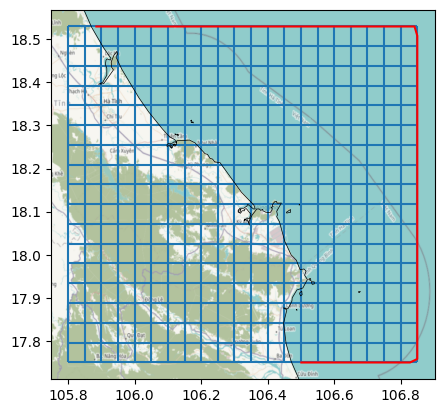

In [4]:
# generate spherical regular grid
mk_object = dfmt.make_basegrid(lon_min, lon_max, lat_min, lat_max, dx=dxy, dy=dxy, crs=crs)

# generate plifile from grid extent and coastlines
bnd_gdf = dfmt.generate_bndpli_cutland(mk=mk_object, res='h', buffer=0.01)
bnd_gdf_interp = dfmt.interpolate_bndpli(bnd_gdf, res=0.03)
pli_polyfile = dfmt.geodataframe_to_PolyFile(bnd_gdf_interp, name=f'{model_name}_bnd')
poly_file = os.path.join(dir_output, f'{model_name}.pli')
pli_polyfile.save(poly_file)

# plot basegrid and polyline
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
bnd_gdf_interp.plot(ax=ax, edgecolor='r')
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 2.93 sec


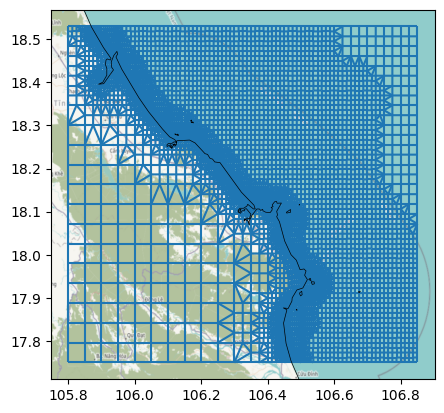

In [5]:
# connect to a coarse version of the GEBCO_2022 dataset on OPeNDAP
# alternatively download your own full resolution cutout from https://download.gebco.net (use a buffer of e.g. 1 degree)
file_nc_bathy = "https://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files/GEBCO_2022/GEBCO_2022_coarsefac08.nc"
data_bathy = xr.open_dataset(file_nc_bathy).elevation
# alternatively you can connect to ETOPO 30s, for which there is also a 15s (15 arcseconds) resolution dataset available
# file_nc_bathy = "https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/30s/30s_surface_elev_netcdf/ETOPO_2022_v1_30s_N90W180_surface.nc"
# data_bathy = xr.open_dataset(file_nc_bathy).z

# subset to area of interest
data_bathy_sel = data_bathy.sel(lon=slice(lon_min-1, lon_max+1), lat=slice(lat_min-1, lat_max+1))

# refine grid
min_edge_size = 300 # in meters
dfmt.refine_basegrid(mk=mk_object, data_bathy_sel=data_bathy_sel, min_edge_size=min_edge_size)

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 2.95 sec
>> reading coastlines: 2.92 sec


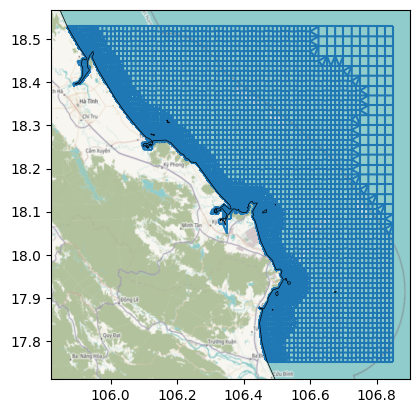

In [6]:
# remove land with GSHHS coastlines
dfmt.meshkernel_delete_withcoastlines(mk=mk_object, res='h')

# derive illegalcells geodataframe
illegalcells_gdf = dfmt.meshkernel_get_illegalcells(mk=mk_object)

# plot
fig, ax = plt.subplots()
mk_object.mesh2d_get().plot_edges(ax,zorder=1)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)


>> reading coastlines: 2.92 sec


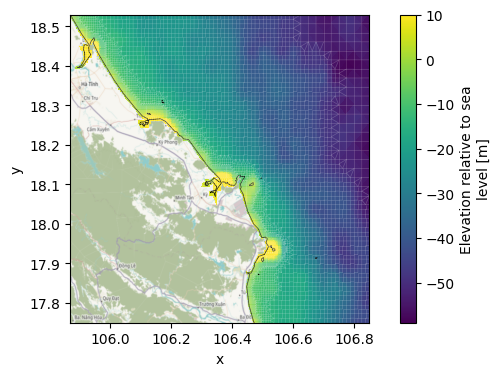

In [7]:
# convert to xugrid
xu_grid_uds = dfmt.meshkernel_to_UgridDataset(mk=mk_object, crs=crs)

# interpolate bathymetry onto the grid
data_bathy_interp = data_bathy_sel.interp(lon=xu_grid_uds.obj.mesh2d_node_x, lat=xu_grid_uds.obj.mesh2d_node_y)
xu_grid_uds['mesh2d_node_z'] = data_bathy_interp.clip(max=10)

# plot bathymetry and grid
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.mesh2d_node_z.ugrid.plot(ax=ax,center=False)
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='white',alpha=0.2)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)
dfmt.plot_coastlines(ax=ax, crs=crs)

# write xugrid grid to netcdf
netfile = os.path.join(dir_output, f'{model_name}_net.nc')
xu_grid_uds.ugrid.to_netcdf(netfile)


## 4. Generate boundary conditions from tidal model and CMEMS (new *.ext file)
To simulate something useful we need boundary conditions for the model. These boundary conditions are forced via the new *.ext file. We initialize a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtModel` instance and append boundaries to it.

We start with the interpolation of tidal components from a global database. In this example we use TPXO8, but other sources are also available. If you are working outside of the Deltares network, only the `*_opendap` sources will be available. The components of the chosen tidal model are interpolated to the points of the `dflowfm.PolyFile` we generated in the previous step and converted to a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ForcingModel` (*.bc file). The resulting tidal boundary condition has a set of tidal components with amplitudes and phases for each boundary point.

Besides tide or waterlevels, we can also add boundary conditions for flow velocities, salinity, temperature and water quality variables like NO3. In this example we download the data from the [Copernicus Marine Service](https://data.marine.copernicus.eu/register) and interpolate it to the points of the `dflowfm.PolyFile`. The resulting netcdf files are also converted to a `dflowfm.ForcingModel` (*.bc file). The resulting boundary conditions contain a timeseries with depth dimension for each boundary point.

### Exercises
- try a different tide model
- add additional WAQ variables like NO3


In [8]:
# generate new format external forcings file (.ext): initial and open boundary condition
ext_file_new = os.path.join(dir_output, f'{model_name}_new.ext')
ext_new = hcdfm.ExtModel()


In [9]:
# interpolate tidal components to boundary conditions file (.bc)
tidemodel = 'tpxo80_opendap' # tidemodel: FES2014, FES2012, EOT20, GTSMv4.1, GTSMv4.1_opendap
dfmt.interpolate_tide_to_bc(ext_new=ext_new, tidemodel=tidemodel, file_pli=poly_file, component_list=None)


> interp mfdataset to all PolyFile points (lat/lon coordinates)
> actual extraction of data from netcdf with .load() (for 71 plipoints at once, this might take a while)
>>time passed: 0.00 sec
Converting 71 plipoints to hcdfm.ForcingModel(): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71. >> done in 0.12 sec


In [10]:
# CMEMS - download spatial fields of salinity, temperature, currents and sea surface height
# you can also add WAQ variables like 'no3' and 'phyc'
# check dfmt.get_conversion_dict() for an overview of parameter/quantity names
dir_output_data_cmems = os.path.join(dir_output_data, 'cmems')
os.makedirs(dir_output_data_cmems, exist_ok=True)
for varkey in ['so','thetao','uo','vo','zos']:
    dfmt.download_CMEMS(varkey=varkey,
                        longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                        date_min=date_min, date_max=date_max,
                        dir_output=dir_output_data_cmems, file_prefix='cmems_', overwrite=overwrite)

# CMEMS - boundary conditions file (.bc) and add to ext_bnd
# you can also add WAQ variables like 'tracerbndNO3' and 'tracerbndPON1'
# check dfmt.get_conversion_dict() for an overview of parameter/quantity names
list_quantities = ['waterlevelbnd','salinitybnd','temperaturebnd','uxuyadvectionvelocitybnd']
dir_pattern = os.path.join(dir_output_data_cmems,'cmems_{ncvarname}_*.nc')
ext_new = dfmt.cmems_nc_to_bc(ext_bnd=ext_new,
                              refdate_str=f'minutes since {ref_date} 00:00:00 +00:00',
                              dir_output=dir_output,
                              list_quantities=list_quantities,
                              tstart=date_min,
                              tstop=date_max, 
                              file_pli=poly_file,
                              dir_pattern=dir_pattern)

#save new ext file
ext_new.save(filepath=ext_file_new) # ,path_style=path_style)


INFO - 2024-07-11T13:39:45Z - You are already logged in. Skipping login.


retrieving time range of CMEMS reanalysis, reanalysis-interim and forecast products (phy)


INFO - 2024-07-11T13:39:45Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:39:45Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:39:47Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:39:51Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:39:51Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:39:53Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:39:58Z - Dataset version was not specified, the latest one was selected: "202406"
INFO - 2024-07-11T13:39:58Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:00Z - Service was not specified, the default one was selected: "arco-geo-series"


The CMEMS 'reanalysis-interim' product will be used.


INFO - 2024-07-11T13:40:04Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:04Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:06Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:40:10Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:10Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:12Z - Service was not specified, the default one was selected: "arco-time-series"


"cmems_so_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_so_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_so_2022-11-03.nc" found and overwrite=False, continuing.


INFO - 2024-07-11T13:40:16Z - You are already logged in. Skipping login.


The CMEMS 'reanalysis-interim' product will be used.


INFO - 2024-07-11T13:40:17Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:17Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:19Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:40:23Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:23Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:25Z - Service was not specified, the default one was selected: "arco-time-series"


"cmems_thetao_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_thetao_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_thetao_2022-11-03.nc" found and overwrite=False, continuing.


INFO - 2024-07-11T13:40:29Z - You are already logged in. Skipping login.


The CMEMS 'reanalysis-interim' product will be used.


INFO - 2024-07-11T13:40:30Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:30Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:32Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:40:37Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:37Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:38Z - Service was not specified, the default one was selected: "arco-time-series"


"cmems_uo_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_uo_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_uo_2022-11-03.nc" found and overwrite=False, continuing.


INFO - 2024-07-11T13:40:43Z - You are already logged in. Skipping login.


The CMEMS 'reanalysis-interim' product will be used.


INFO - 2024-07-11T13:40:43Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:43Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:45Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:40:50Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:50Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:52Z - Service was not specified, the default one was selected: "arco-time-series"


"cmems_vo_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_vo_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_vo_2022-11-03.nc" found and overwrite=False, continuing.


INFO - 2024-07-11T13:40:56Z - You are already logged in. Skipping login.


The CMEMS 'reanalysis-interim' product will be used.


INFO - 2024-07-11T13:40:57Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:40:57Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:40:59Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-11T13:41:03Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-11T13:41:03Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-11T13:41:05Z - Service was not specified, the default one was selected: "arco-time-series"


"cmems_zos_2022-11-01.nc" found and overwrite=False, continuing.
"cmems_zos_2022-11-02.nc" found and overwrite=False, continuing.
"cmems_zos_2022-11-03.nc" found and overwrite=False, continuing.
processing quantity: waterlevelbnd
loading mfdataset of 3 files with pattern(s) ['cmems_zos_*.nc']
variable zos renamed to waterlevelbnd
> interp mfdataset to all PolyFile points (lat/lon coordinates)
> actual extraction of data from netcdf with .load() (for 71 plipoints at once, this might take a while)
>>time passed: 0.02 sec
Converting 71 plipoints to hcdfm.ForcingModel(): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71. >> done in 0.04 sec
processing quantity: salinitybnd
loading mfdataset of 3 files with pattern(s) ['cmems_so_*.nc']
variable so renamed to salinitybnd
dimension depth renamed to z
varname depth renamed to z
> interp mfdat

>> reading coastlines: 2.93 sec
>> reading coastlines: 2.92 sec


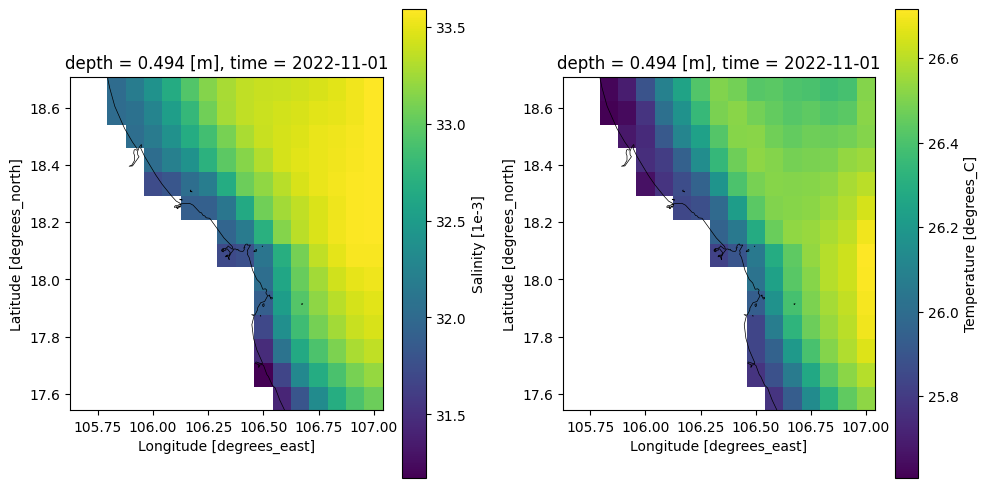

In [11]:
# plot downloaded CMEMS data
file_cmems = os.path.join(dir_output_data,'cmems','*.nc')
ds_cmems = xr.open_mfdataset(file_cmems)
ds_cmems

# plot
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ds_cmems.so.isel(time=0, depth=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_cmems.thetao.isel(time=0, depth=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


(-58.96910790071473, 0.02965003252029419)

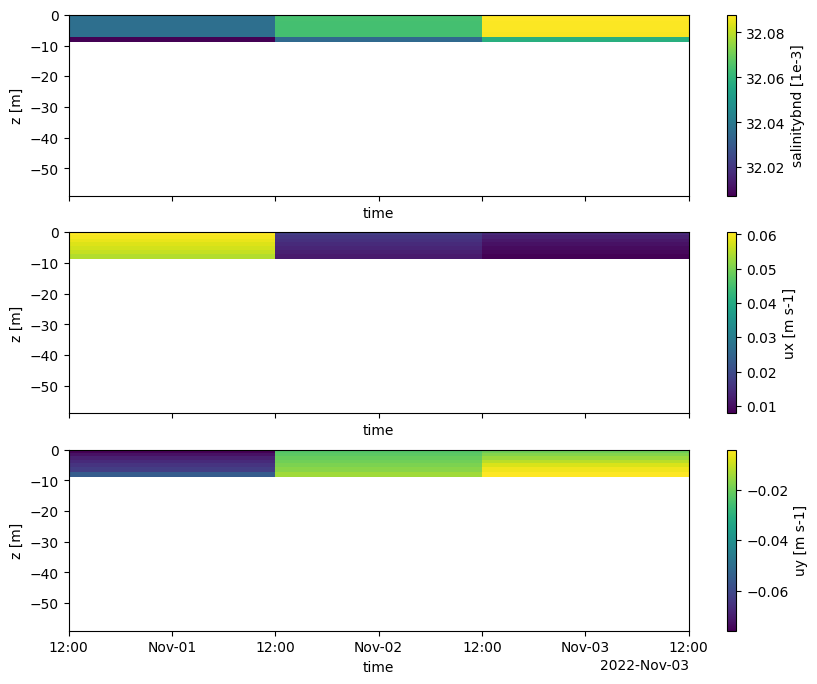

In [12]:
# plot interpolated CMEMS data (boundary conditions in .bc)
file_bc_sal = os.path.join(dir_output, f'salinitybnd_CMEMS.bc')
bc_obj_sal = hcdfm.ForcingModel(file_bc_sal)
forcing_xr_sal = dfmt.forcinglike_to_Dataset(bc_obj_sal.forcing[0], convertnan=True)

file_bc_uxuy = os.path.join(dir_output,f'uxuyadvectionvelocitybnd_CMEMS.bc')
bc_obj_uxuy = hcdfm.ForcingModel(file_bc_uxuy)
forcing_xr_uxuy = dfmt.forcinglike_to_Dataset(bc_obj_uxuy.forcing[0], convertnan=True)

# plot
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10,8))
forcing_xr_sal['salinitybnd'].T.plot(ax=ax1)
forcing_xr_uxuy['ux'].T.plot(ax=ax2)
forcing_xr_uxuy['uy'].T.plot(ax=ax3)
ax1.set_ylim(xu_grid_uds.mesh2d_node_z.min(), None)

## 5. Generate CMEMS ini conditions and ERA5 meteo forcing (old *.ext file)
We will supply more boundary conditions to the model via the old *.ext file. We initialize a [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtOldModel` instance and append boundaries to it. These boundaries are [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.ExtOldForcing` instances.

In order to avoid long spinup times we can use spatially varying initial conditions. We derive these again from the data downloaded from the [Copernicus Marine Service](https://data.marine.copernicus.eu/register). The netcdf files are subsetted in time and written to the netcdf format expected by D-Flow FM.

Another important forcing is meteo. In this example ERA5 meteo data is retrieved from the Copernicus [Climate Data Store](https://cds.climate.copernicus.eu/user/register). The netcdf files are merged in time and written to the netcdf format expected by D-Flow FM.

### Exercises
- extend the amount of meteo parameters


In [13]:
# generate old format external forcings file (.ext): spatial data
ext_file_old = os.path.join(dir_output, f'{model_name}_old.ext')
ext_old = hcdfm.ExtOldModel()

# CMEMS - initial conditions
# salinity/temperature can only be added in case of 3D model and iniwithnudge
ext_old = dfmt.cmems_nc_to_ini(ext_old=ext_old,
                               dir_output=dir_output,
                               list_quantities=['waterlevelbnd'], # list_quantities,
                               tstart=date_min,
                               dir_pattern=dir_pattern)

# ERA5 - download spatial fields of air pressure, wind speeds and Charnock coefficient
dir_output_data_era5 = os.path.join(dir_output_data, 'ERA5')
os.makedirs(dir_output_data_era5, exist_ok=True)
    
varlist_list = [['msl','u10n','v10n','chnk']]

for varlist in varlist_list:
    for varkey in varlist:
        dfmt.download_ERA5(varkey, 
                           longitude_min=lon_min, longitude_max=lon_max, latitude_min=lat_min, latitude_max=lat_max,
                           date_min=date_min, date_max=date_max,
                           dir_output=dir_output_data_era5, overwrite=overwrite)

# ERA5 meteo - convert to netCDF for usage in Delft3D FM
ext_old = dfmt.preprocess_merge_meteofiles_era5(ext_old=ext_old,
                                                varkey_list=varlist_list,
                                                dir_data=dir_output_data_era5,
                                                dir_output=dir_output,
                                                time_slice=slice(date_min, date_max))

ext_old.save(filepath=ext_file_old) # , path_style=path_style)


2024-07-11 13:41:18,504 INFO Welcome to the CDS


loading mfdataset of 3 files with pattern(s) ['cmems_zos_*.nc']
variable zos renamed to waterlevelbnd
writing file


2024-07-11 13:41:18,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/dummy
2024-07-11 13:41:18,576 INFO Welcome to the CDS
2024-07-11 13:41:18,579 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/dummy
2024-07-11 13:41:18,653 INFO Welcome to the CDS
2024-07-11 13:41:18,656 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/dummy
2024-07-11 13:41:18,735 INFO Welcome to the CDS


found CDS credentials and authorization successful
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_msl_2022-11.nc" found and overwrite=False, continuing.
found CDS credentials and authorization successful
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_u10n_2022-11.nc" found and overwrite=False, continuing.
found CDS credentials and authorization successful
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_v10n_2022-11.nc" found and overwrite=False, continuing.


2024-07-11 13:41:18,739 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/dummy


found CDS credentials and authorization successful
retrieving data from 2022-11 to 2022-11 (freq=<MonthEnd>)
"era5_chnk_2022-11.nc" found and overwrite=False, continuing.
>> opening multifile dataset of 4 files (can take a while with lots of files): 0.03 sec
>> writing file (can take a while): 0.03 sec


>> reading coastlines: 2.93 sec
>> reading coastlines: 2.91 sec


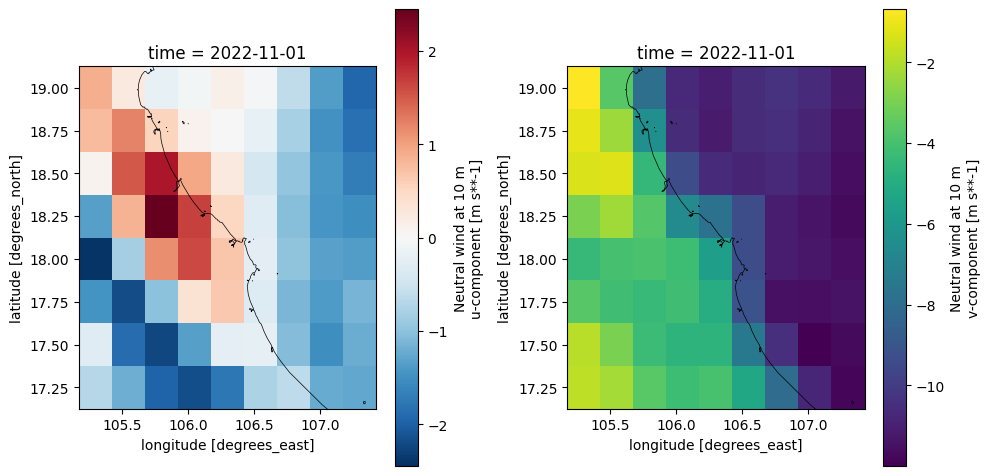

In [14]:
# plot converted ERA5 data
file_era5 = os.path.join(dir_output,'data','ERA5','*.nc')
ds_era5 = xr.open_mfdataset(file_era5)
ds_era5

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ds_era5.u10n.isel(time=0).plot(ax=ax1)
dfmt.plot_coastlines(ax=ax1, crs=crs)
ds_era5.v10n.isel(time=0).plot(ax=ax2)
dfmt.plot_coastlines(ax=ax2, crs=crs)
fig.tight_layout()


## 6. Generate obsfile
The D-Flow FM model wil have mapoutput and hisoutput. In order for the hisoutput to not be empty, some dummy stations are generated at the locations random grid cells.

### Exercises
- the observation points are randomly generated, add obspoints near actual cities/harbours/islands instead (variable `obs_pd`)


               x          y            name
5073  106.009376  18.401203  x106p01_y18p40
5173  106.398438  18.122001  x106p40_y18p12
5644  106.529688  17.898095  x106p53_y17p90
752   106.507292  17.980921  x106p51_y17p98
3873  106.218751  18.512671  x106p22_y18p51
3066  106.481250  18.398344  x106p48_y18p40
3553  106.531251  18.226610  x106p53_y18p23
5539  106.489063  17.754315  x106p49_y17p75
4733  106.509376  17.758631  x106p51_y17p76
5852  106.345313  18.127735  x106p35_y18p13
>> reading coastlines: 2.91 sec


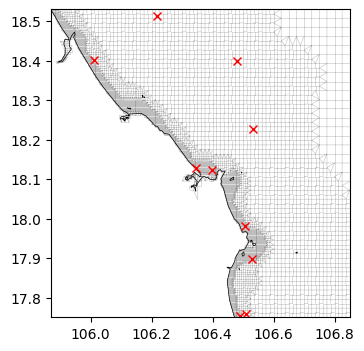

In [15]:
# generate obspoints on all grid faces
xpts = xu_grid_uds.grid.face_x
ypts = xu_grid_uds.grid.face_y
npts = [f'x{x:.2f}_y{y:.2f}'.replace('.','p') for x,y in zip(xpts,ypts)]
obs_pd = pd.DataFrame(dict(x=xpts,y=ypts,name=npts))

# subselect n arbitary obspoints and plot
n = 10
ipts = np.random.randint(0, len(obs_pd), n)
obs_pd = obs_pd.iloc[ipts]
print(obs_pd)
fig, ax = plt.subplots(figsize=(8,4))
xu_grid_uds.grid.plot(ax=ax,linewidth=0.5,color='k',alpha=0.2)
ax.plot(obs_pd['x'],obs_pd['y'],'rx')
dfmt.plot_coastlines(ax=ax, crs=crs)

# save obsfile
file_obs = os.path.join(dir_output, f'{model_name}_obs.xyn')
obs_pd.to_csv(file_obs, sep=' ', header=False, index=False, float_format='%.6f')


## 7. Generate mdu file
In order for the model to run, we need a model definition file. In case of D-Flow FM this is a *.mdu file, represented by the [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) `dflowfm.FMModel`. This is initialized and many of the files we generated above (network, extfiles, obsfile) are linked here. You can visualize the resulting model tree with `mdu.show_tree()`. We can also adjust any of the parameters in the *.mdu file by setting them here.

### Exercises
- convert this 2D model into a 3D model, for instance like in [preprocess_modelbuilder.py](https://github.com/Deltares/dfm_tools/blob/main/tests/examples/preprocess_modelbuilder.py).
- enable the computation of salinity and temperature in the mdu (`salinity`=1 and `temperature`=5)
- use the fourier smoothing time (`tlfSmo`) to make the model spinup less chaotic


In [16]:
# initialize mdu file and update settings
mdu_file = os.path.join(dir_output, f'{model_name}.mdu')
mdu = hcdfm.FMModel()

# add the grid (_net.nc, network file)
mdu.geometry.netfile = netfile

# create and add drypointsfile if there are any cells generated that will result in high orthogonality
if len(illegalcells_gdf) > 0:
    illegalcells_polyfile = dfmt.geodataframe_to_PolyFile(illegalcells_gdf)
    illegalcells_polyfile.save("illegalcells.pol")
    mdu.geometry.drypointsfile = [illegalcells_polyfile]

# support for initial sal/tem fields via iniwithnudge, this requires 3D model
# mdu.geometry.kmx = 5
# mdu.physics.iniwithnudge = 2

# add the external forcing files (.ext)
mdu.external_forcing.extforcefile = ext_file_old
mdu.external_forcing.extforcefilenew = ext_new

# update time settings
mdu.time.refdate = pd.Timestamp(ref_date).strftime('%Y%m%d')
mdu.time.tunit = 'S'
mdu.time.dtmax = 30
mdu.time.startdatetime = pd.Timestamp(date_min).strftime('%Y%m%d%H%M%S')
mdu.time.stopdatetime = pd.Timestamp(date_max).strftime('%Y%m%d%H%M%S')
mdu.time.autotimestep = 3

# update output settings
mdu.output.obsfile = file_obs
mdu.output.hisinterval = [60]
mdu.output.mapinterval = [1800]#[86400]
mdu.output.rstinterval = [0]
mdu.output.statsinterval = [3600]

# save .mdu file
mdu.save(mdu_file) # ,path_style=path_style)

# make all paths relative (might be properly implemented in https://github.com/Deltares/HYDROLIB-core/issues/532)
dfmt.make_paths_relative(mdu_file)

## 8. Generate DIMR and bat file
In order to run the model via DIMR we need a `dimr_config.xml` file. If you are running this notebook on a Windows platform, a *.bat file will also be created with which you can run the model directly. In order for this to work you need to update the `dimrset_folder` to the path where the `x64` and or `lnx64` folder is located. Provide `None` if you have no D-Flow FM executable available on your system.


In [17]:
nproc = 1 # number of processes
dimrset_folder = None # alternatively r"c:\Program Files\Deltares\Delft3D FM Suite 2023.03 HMWQ\plugins\DeltaShell.Dimr\kernels" #alternatively r"p:\d-hydro\dimrset\weekly\2.25.17.78708"
dfmt.create_model_exec_files(file_mdu=mdu_file, nproc=nproc, dimrset_folder=dimrset_folder)


writing dimr_config.xml
no dimrset_folder provided, cannot write bat/sh file


## 9. Visualize model tree

In [18]:
# visualize the model tree, show_tree is available for all HYDROLIB-core model components
mdu_obj = hcdfm.FMModel(mdu_file)
mdu_obj.show_tree()


  c:\DATA\dfm_tools\docs\notebooks\Vietnam_model\Vietnam.mdu
    Geometry
     ∟ Vietnam_net.nc
    ExternalForcing
     ∟ Vietnam_old.ext
       ∟ ExtOldForcing
         ∟ initialwaterlevel_2022-11-01_00-00-00.nc
       ∟ ExtOldForcing
         ∟ era5_msl_u10n_v10n_chnk_20221101to20221103_ERA5.nc
     ∟ Vietnam_new.ext
       ∟ Boundary
         ∟ Vietnam.pli
         ∟ tide_tpxo80_opendap.bc
       ∟ Boundary
         ∟ Vietnam.pli
         ∟ waterlevelbnd_CMEMS.bc
       ∟ Boundary
         ∟ Vietnam.pli
         ∟ salinitybnd_CMEMS.bc
       ∟ Boundary
         ∟ Vietnam.pli
         ∟ temperaturebnd_CMEMS.bc
       ∟ Boundary
         ∟ Vietnam.pli
         ∟ uxuyadvectionvelocitybnd_CMEMS.bc
    Output
     ∟ Vietnam_obs.xyn


## 10. Run the model and do the exercises
### Running the model and post-processing the results
- run the model with the `run_parallel.bat` file if you work on Windows.
- the modeloutput can visualized with (the code in) the [postprocessing notebook](https://github.com/Deltares/dfm_tools/blob/main/docs/notebooks/postprocessing_example.ipynb).

### Exercises
- you can change the model input as suggested in the exercises above and rerun the model builder and the model.
- It might be useful to check the [D-Flow FM manual](https://content.oss.deltares.nl/delft3d/D-Flow_FM_User_Manual.pdf) for background information.
- You can also check the more advanced example in [preprocess_modelbuilder.py](https://github.com/Deltares/dfm_tools/blob/main/tests/examples/preprocess_modelbuilder.py) to get started.

### Advanced exercises
- add a observation cross-section near a harbour or river
- add a river inflow as a boundary condition (.pli and .bc in new format .ext or .pli and .tim in old format .ext)


# 